In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from dataset import get_datasets
from models import Autoencoder, VariationalAutoencoder, LitAutoencoder, LitVariationalAutoencoder

In [2]:
Z_SIZE_AE = 10
Z_SIZE_VAE = 10

In [3]:
VAE_PATH = '../lightning_logs/version_1/checkpoints/epoch=18-step=91199.ckpt'
AE_PATH = '../lightning_logs/version_4/checkpoints/epoch=29-step=143999.ckpt'

In [4]:
_, _, data = get_datasets(batch_size=1, root='../data', download=False)

# Load models

In [5]:
ae = LitAutoencoder.load_from_checkpoint(
    AE_PATH,
    autoencoder=Autoencoder(Z_SIZE_AE)
).autoencoder

In [6]:
vae = LitVariationalAutoencoder.load_from_checkpoint(
    VAE_PATH,
    autoencoder=VariationalAutoencoder(z_size=Z_SIZE_VAE)
).autoencoder

# Compare reconstruction

In [7]:
def sample_reconstruction(ae, vae, iterator, samples=3, **kwargs):
    fig, ax = plt.subplots(3, samples, **kwargs)
    ae.cuda().eval()
    vae.cuda().eval()
    for i in range(samples):
        with torch.no_grad():
            x, y = next(iterator)
            rec_ae = ae(x.cuda())[0].cpu()
            rec_vae = vae(x.cuda())[0].cpu()
        ax_original, ax_ae, ax_vae = ax[0, i], ax[1, i], ax[2, i]
        # print original image
        ax_original.set_title(f'Label: {y} original')
        ax_original.imshow(x.reshape(28, 28), cmap='gray')
        ax_original.set_xticks([]), ax_original.set_yticks([])

        # print ae reconstruction
        ax_ae.set_title(f'Label: {y} AE')
        ax_ae.imshow(rec_ae.reshape(28, 28), cmap='gray')
        ax_ae.set_xticks([]), ax_ae.set_yticks([])

        # print vae reconstruction
        ax_vae.set_title(f'Label: {y} VAE')
        ax_vae.imshow(rec_vae.reshape(28, 28), cmap='gray')
        ax_vae.set_xticks([]), ax_vae.set_yticks([])
    fig.tight_layout()
    plt.show()

In [ ]:
iterator = iter(data)
sample_reconstruction(ae, vae, iterator, figsize=(10, 10))

# Test generation

In [ ]:
def generate_sample(ae, vae, z_size=100, samples=3, **kwargs):
    fig, ax = plt.subplots(2, samples, **kwargs)
    ae.cuda().eval()
    vae.cuda().eval()
    for i in range(samples):
        with torch.no_grad():
            noise = torch.randn(z_size).cuda()
            img_ae = ae.decoder(noise).cpu()
            img_vae = vae.decoder(noise)[0].cpu()
        ax_ae, ax_vae = ax[0, i], ax[1, i]

        ax_ae.set_title('AE')
        ax_ae.imshow(img_ae.reshape(28, 28), cmap='gray')
        ax_ae.set_xticks([]), ax_ae.set_yticks([])

        ax_vae.set_title('VAE')
        ax_vae.imshow(img_vae.reshape(28, 28), cmap='gray')
        ax_vae.set_xticks([]), ax_vae.set_yticks([])
    fig.tight_layout()
    plt.show()

In [ ]:
generate_sample(ae, vae, z_size=10, samples=3, figsize=(10, 10))

# Check distribution of z vector in VAE

In [24]:
def check_dimensionality(vae, z_size, data):
    latents = np.zeros((len(data), z_size))
    vae.cuda()
    for i, (x, _) in enumerate(data):
        latent = vae.encoder(x.cuda())[0].cpu().detach().numpy()
        latents[i] = latent
    return latents

In [26]:
distribution = check_dimensionality(vae, Z_SIZE_VAE, data)

In [37]:
def normal_distribution(mean, sigma):
    
    def _normal(x):
        return np.exp(-np.square(x-mean)/2 * sigma ** 2)/(np.sqrt(2*np.pi*sigma**2))
    return _normal

In [105]:
def plot_distribution(latents, bins=15, max_dim=10):
    fig, ax = plt.subplots(2, max_dim // 2, figsize=(20, 8))
    for i in range(max_dim // 2):
        for j in range(2):
            idx = i * 2 + j
            dist = latents[:, idx]
            ax[j, i].set_title(f'Dimension: {idx}')
            ax[j, i].hist(dist, bins=bins)
    fig.tight_layout()
    plt.show()

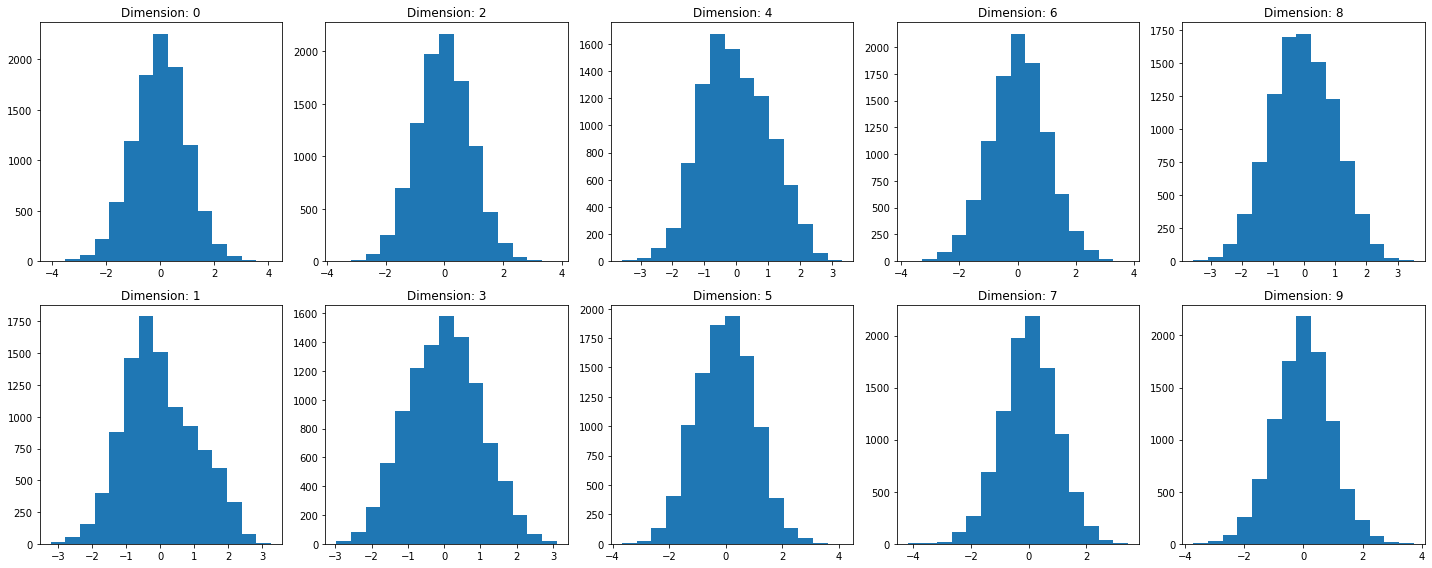

In [106]:
plot_distribution(distribution)